In [1]:
import sys
sys.path.append("../scripts/")
from gridmap import *
from mdp import *
import math
import copy
import random
import numpy as np
from matplotlib.animation import PillowWriter    #アニメーション保存用
#%matplotlib notebook

In [2]:
class Actor():
    def __init__(self, grid_map_world, epsilon=0.9):
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.actions = np.arange(9)
        self.q = np.full(self.grid_map.shape+tuple([9]), 0.0)
        self.epsilon = epsilon
    
    # ソフトマックス関数
    def softmax(self, x):
        c = np.max(x)
        return np.exp(x - c) / np.sum(np.exp(x - c), axis=0)
    
    #方策
    def policy(self, s):
        if(random.random() < self.epsilon):
            a = np.random.choice(self.actions, 1, p=self.softmax(self.Q(s)))[0]
        else:
            a = int(random.random() * 8) + 1
        return a
        
    # 移動
    def moveRobot(self, s, a):
        grid = copy.copy(s)
        if(a == 1 or a == 2 or a == 8):
            grid[0] += 1
        elif(a == 4 or a == 5 or a == 6):
            grid[0] -= 1
        if(a == 2 or a == 3 or a == 4):
            grid[1] += 1
        elif(a == 6 or a == 7 or a == 8):
            grid[1] -= 1
        return grid
        
    def Q(self, s, a=None):
        if(a == None):
            return self.q[s[0]][s[1]]
        else:
            return self.q[s[0][s[1]]][a]
    
    def argmaxQ(self, s):
        return np.argmax(self.q[s[0]][s[1]])
    
class Critic():
    def __init__(self, grid_map_world):
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.v = np.full(self.grid_map.shape, 0.0)    #状態価値関数
        self.v[self.world.goal_index[0]][self.world.goal_index[1]] = 100.0
        
    def V(self, s):
        if(self.isOutOfBounds(s)):
            return 0
        elif(self.isObstacle(s)):
            return 0
        else:
            return self.v[s[0]][s[1]]
     
    def isObstacle(self, s):
        if(self.grid_map[s[0]][s[1]] == '0'):
            return True
        else:
            return False

    def isOutOfBounds(self, s):
        if(s[0]<0 or s[0]>self.grid_map.shape[0]-1):
            return True
        elif(s[1]<0 or s[1]>self.grid_map.shape[1]-1):
            return True
        return False
    
class ActorCritic():
    def __init__(
        self, grid_map_world, actor, critic, gamma=0.9, learning_rate=0.1,
        drawPI=False, drawQ=False, drawPath=False, drawQPath=False
    ):
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.actor = actor
        self.critic = critic
        self.gamma = gamma
        self.learning_rate = learning_rate
        
        self.drawPIflag = drawPI
        self.drawQflag = drawQ
        self.drawPathflag = drawPath
        self.drawQPathflag = drawQPath
    
    def draw(self, ax, elems):
        traversed_grids = self.episode(ax, elems)    #1エピソード実行
        
        #描画
        if(self.drawPIflag):    #方策
            self.drawPI(ax, elems)
        if(self.drawQflag):    #行動価値関数
            self.drawQ(ax, elems)
        if(self.drawQPathflag):    #最大行動価値関数の方策経路
            self.drawQPath(ax, elems)
        if(self.drawPathflag):    #エピソード内の経路
            self.drawTraversedPath(traversed_grids, ax, elems)
    
    def episode(self, ax, elems):
        s_ = copy.copy(self.world.start_index)
        traversed_grids = []
        for i in range(600):
            s = copy.copy(s_)
            a = self.actor.policy(s)
            s_ = self.actor.moveRobot(s, a)   #移動
            
            r = -2.0 - self.distance(s, s_)
            if(self.isOutOfBounds(s_) or self.isObstacle(s_)):
                r -= 1000
            elif(s == s_):
                r -= 10
            
            gain = r + self.gamma * self.critic.V(s_)
            estimated = self.critic.V(s)
            td = gain - estimated
            actor.q[s[0]][s[1]][a] += self.learning_rate * td
            critic.v[s[0]][s[1]] += self.learning_rate * td
            
            if(self.isOutOfBounds(s_) or self.isObstacle(s_) or self.isGoal(s_)):
                break
            traversed_grids.append(copy.copy(s_))
        return traversed_grids
    
    def distance(self, s1, s2):
        return math.sqrt((s1[0] - s2[0])**2 + (s1[1] - s2[1])**2)
    
    def isGoal(self, s):
        if(self.grid_map[s[0]][s[1]] == '3'):
            return True
        else:
            return False
     
    def isObstacle(self, s):
        if(self.grid_map[s[0]][s[1]] == '0'):
            return True
        else:
            return False

    def isOutOfBounds(self, s):
        if(s[0]<0 or s[0]>self.grid_map.shape[0]-1):
            return True
        elif(s[1]<0 or s[1]>self.grid_map.shape[1]-1):
            return True
        return False
    
    #方策描画
    def drawPI(self, ax, elems):
        for x in range(len(self.grid_map)):
            for y in range(len(self.grid_map[0])):
                if(self.grid_map[x][y] == '0'):
                    continue
                c_num = int(self.maxQAgent([x, y]))
                if(c_num == 0):
                    c = "black"
                elif(c_num == 1):
                    c = "saddlebrown"
                elif(c_num == 2):
                    c = "magenta"
                elif(c_num == 3):
                    c = "blue"
                elif(c_num == 4):
                    c = "cyan"
                elif(c_num == 5):
                    c = "green"
                elif(c_num == 6):
                    c = "lime"
                elif(c_num == 7):
                    c = "yellow"
                elif(c_num == 8):
                    c = "orange"
                elif(c_num == 9):
                    c = "red"
                else:
                    c = "white"
                r = patches.Rectangle(
                    xy=(x*self.world.grid_step[0], y*self.world.grid_step[1]),
                    height=self.world.grid_step[0],
                    width=self.world.grid_step[1],
                    color=c,
                    fill=True,
                    alpha=0.8
                )
                elems.append(ax.add_patch(r))

    #行動価値関数描画
    def drawQ(self, ax, elems):
        for x in range(len(self.grid_map)):
            for y in range(len(self.grid_map[0])):
                if(self.grid_map[x][y] == '0'):
                    continue
                #map1 : 20
                #cost_adj = 7    #map2
                c_num = -self.maxQ([x, y])
                c_num = int(c_num * 7) #Black→Blue
                if(c_num > 0xff): #Blue → Cyan
                    c_num = (c_num-0xff)*16*16 + 0xff
                    if(c_num > 0xffff): #Cyan → Green
                        c_num = 0xffff - int((c_num-0x100ff)*4/256)
                        if(c_num < 0xff00): #Green →Yellow
                            c_num = (0xff00-c_num)*65536+0xff00
                            if(c_num > 0xffff00): #Yellow → Red
                                c_num = 0xffff00 - int((c_num-0xffff00)*0.5/65536)*256
                c = '#' + format(int(c_num), 'x').zfill(6)
                r = patches.Rectangle(
                    xy=(x*self.world.grid_step[0], y*self.world.grid_step[1]),
                    height=self.world.grid_step[0],
                    width=self.world.grid_step[1],
                    color=c,
                    fill=True,
                    alpha=0.8
                )
                elems.append(ax.add_patch(r))
     
    #エピソード内の経路を描画
    def drawTraversedPath(self, grids, ax, elems):
        for grid in grids:
            r = patches.Rectangle(
                xy=(grid[0]*self.world.grid_step[0], grid[1]*self.world.grid_step[1]),
                height=self.world.grid_step[0],
                width=self.world.grid_step[1],
                color="red",
                fill=True,
                alpha=0.5
            )
            elems.append(ax.add_patch(r))
    
    #行動価値関数を最大にする方策で動いた場合の経路を描画
    def drawQPath(self, ax, elems):
        robot_state = copy.copy(self.world.start_index)
        for i in range(100):
            robot_state_old = copy.copy(robot_state)
            a = self.actor.argmaxQ(robot_state)  
            if(a == 1 or a == 2 or a == 8):
                robot_state[0] += 1
            elif(a == 4 or a == 5 or a == 6):
                robot_state[0] -= 1
            if(a == 2 or a == 3 or a == 4):
                robot_state[1] += 1
            elif(a == 6 or a == 7 or a == 8):
                robot_state[1] -= 1
            if(a == 0):
                r = patches.Rectangle(
                    xy=(robot_state[0]*self.world.grid_step[0], robot_state[1]*self.world.grid_step[1]),
                    height=self.world.grid_step[0],
                    width=self.world.grid_step[1],
                    color="black",
                    fill=True,
                    alpha=0.8
                )
                elems.append(ax.add_patch(r))
                break
                
            if(robot_state == self.world.goal_index):
                break
            
            if(self.isOutOfBounds(robot_state) and self.isObstacle(robot_state)):
                break
            
            r = patches.Rectangle(
                xy=(robot_state[0]*self.world.grid_step[0], robot_state[1]*self.world.grid_step[1]),
                height=self.world.grid_step[0],
                width=self.world.grid_step[1],
                color="blue",
                fill=True,
                alpha=0.5
            )
            elems.append(ax.add_patch(r))

<IPython.core.display.Javascript object>


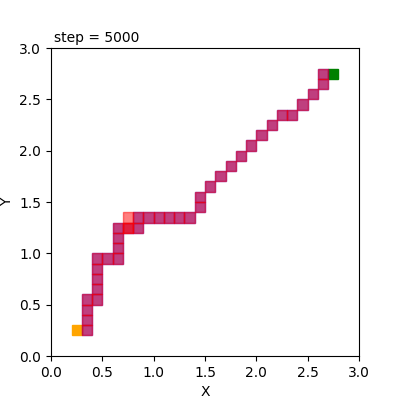

In [3]:
time_span = 500
time_interval = 0.1

grid_step = np.array([0.1, 0.1])
grid_num = np.array([30, 30])

map_data = "../csvmap/map1.csv"

world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
actor = Actor(world)
critic = Critic(world)
world.append(ActorCritic(world, actor, critic, gamma=0.9, learning_rate=0.05, drawPath=True, drawQPath=True))

world.draw()
#world.ani.save('actor_critic_map1.gif', writer='pillow', fps=60)    #アニメーション保存